# Python Imports

In [ ]:
import re
import datetime
import numpy as np
import pandas as pd
import csv
import random
from google.colab import files
!pip install pandas_schema
!pip install python-louvain
import pandas as pd
import pandas_schema
from pandas_schema import Column
from pandas_schema.validation import CustomElementValidation
import numpy as np
from decimal import *
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
!pip install bokeh
from bokeh.io import output_notebook, show, save
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine, FactorRange, HoverTool
from bokeh.plotting import figure
from bokeh.plotting import from_networkx
import networkx as nx
from bokeh.palettes import Blues8, Reds8, Purples8, Oranges8, Viridis8, Spectral8, Plasma256, d3, Turbo256
from bokeh.transform import linear_cmap
from networkx.algorithms import community
from bokeh.models import EdgesAndLinkedNodes, NodesAndLinkedEdges
output_notebook()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Utility Functions

In [ ]:
default_date_format ='%d/%m/%Y'
#
def DownloadDataFrame(df, filename):
  df.to_csv(filename, encoding = 'utf-8-sig', index=False, quoting=csv.QUOTE_NONNUMERIC)
  files.download(filename)
#
def ResetDFIndex(df):
  df.index = pd.RangeIndex(len(df.index))
  df.index = range(len(df.index))
  return df
#
def CreateSubDataSet(df, columns, unique, sort):
  df = CreateDatasetFromColabUsers(df)[columns].copy()
  if(sort):
    df = df.sort_values(sort, ascending=True)
    if(unique):
      idx = df[sort].drop_duplicates().index
      event_types = df.loc[idx,:]
  return ResetDFIndex(event_types)
#
def ExtractEventTypes(df, download):
  event_type_ids = CreateSubDataSet(df, ['event_type_id', 'event_type_name'], True, 'event_type_id')
  print(event_type_ids.shape)
  event_type_names = CreateSubDataSet(df, ['event_type_id', 'event_type_name'], True, 'event_type_name')
  print(event_type_names.shape)
  if(len(event_type_ids) != len(event_type_names)):
    print("event_type_id and event_type_name counts are different.", len(event_type_ids), "ids", len(event_type_names), "names")
  if(download):
    DownloadDataFrame(event_type_ids, "event_type_ids.csv")
    DownloadDataFrame(event_type_names, "event_type_names.csv")
  return event_type_ids if len(event_type_ids) < len(event_type_names) else event_type_names
#
def check_decimal(dec):
    try:
        Decimal(dec)
    except InvalidOperation:
        return False
    return True
#
def check_int(num):
    try:
        int(num)
    except ValueError:
        return False
    return True
#
def check_string(test_string):
    return check_null(test_string) and len(str(test_string)) > 0
#
def check_date(date):
  try:
      datetime.datetime.strptime(date, default_date_format)
      return True
  except ValueError:
      return False
  #return check_string(date) and re.match(r'(\d{4})-(\d{2})-(\d{2}) (\d{1,2}):(\d{2})', date) is not None
#
print("check_date should be false: ", check_date(""))
print("check_date should be false: ", check_date("2022-05-18"))
print("check_date should be true: ", check_date("03/03/2013"))
def check_null(d):
    return not(d is None)
#
# define validation elements
decimal_validation = [CustomElementValidation(lambda d: check_decimal(d), 'invalid decimal')]
int_validation = [CustomElementValidation(lambda i: check_int(i), 'invalid integer')]
null_validation = [CustomElementValidation(lambda d: check_null(d), 'field cannot be null')]
string_validation = [CustomElementValidation(lambda s: check_string(s), 'invalid string')]
date_validation = [CustomElementValidation(lambda s: check_date(s), 'invalid date')]
#
#
def validate_colab_events(file, parse_dates):
    print("validating colab_events file")
    # read the data
    data = ReadCSV(file, parse_dates)
    # define validation schema
    schema = pandas_schema.Schema([
            Column('event_id', null_validation+int_validation),
            Column('user_id', null_validation+int_validation),
            Column('description', string_validation),
            Column('status', null_validation + string_validation),
            Column('created_at', date_validation),
            Column('event_type_id', null_validation + int_validation),
            Column('event_type_name', null_validation + string_validation)
            ])
    # apply validation
    errors = schema.validate(data)
    errors_index_rows = [e.row for e in errors]
    data_clean = data.drop(index=errors_index_rows)
    if(len(errors) > 0):
      # save data
      #data_clean.update('"' + data_clean[['description', 'status', 'created_at', 'event_type_name']].astype(str) + '"')
      #data_clean['event_type_id'] = data_clean['event_type_id'].astype('int')
      print(data.shape)
      print(data_clean.shape)
      #DownloadDataFrame(data_clean, "colab_events_cleaned.csv")
      DownloadDataFrame(pd.DataFrame({'errors':errors}), "data_errors.txt")
      print("Errors found on CSV schema. Check out the data_errors.txt")
      return False
    else:
      print("File is clean")
      return True
#
def tipify_colab_events(df):
  df.fillna(-1, inplace=True)
  df['event_id'] = df['event_id'].astype('int')
  df['user_id'] = df['user_id'].astype('int')
  df['event_type_id'] = df['event_type_id'].astype('int')
  return df
#
def validate_colab_users(file, parse_dates):
    # read the data
    print("validating colab_users file")
    data = ReadCSV(file, parse_dates).head(1)
    # define validation schema
    schema = pandas_schema.Schema([
            Column('colab_user_id', null_validation+int_validation),
            Column('gender', null_validation),
            Column('birth_date', null_validation),
            Column('city_id', null_validation),
            Column('city_name', string_validation),
            Column('state_id', null_validation),
            Column('state_name', null_validation + string_validation),
            Column('created_at', date_validation),
            Column('last_sign_in_at', date_validation),
            Column('device', {})
            ])
    print(data.columns)
    # apply validation
    errors = schema.validate(data)
    errors_index_rows = [e.row for e in errors]
    data_clean = data.drop(index=errors_index_rows)
    if(len(errors) > 0):
      # save data
      print(data.shape)
      print(data_clean.shape)
      #DownloadDataFrame(data_clean, "colab_users_cleaned.csv")
      DownloadDataFrame(pd.DataFrame({'errors':errors}), "user_errors.txt")
      print("Errors found on CSV schema. Check out the user_errors.txt")
      return False
    else:
      print("File is clean")
      return True
#
def tipify_colab_users(df):
  df.fillna("", inplace=True)
  df['colab_user_id'] = df['colab_user_id'].astype('int')
  df['city_id'] = df['city_id'].astype('int')
  df['state_id'] = df['state_id'].astype('int')
  return df
#
def tipify_colab_followers(df):
  df.fillna(-1, inplace=True)
  df['source'] = df['source'].astype('int')
  df['target'] = df['target'].astype('int')
  return df
#
def CreateDatasetFromColabEvents(df):
  dataset = df.copy()
  return dataset
#
#
def CreateDatasetFromColabUsers(df):
  dataset = df.copy()
  return dataset
#
def ReadCSV(filename, parse_dates):
  df = pd.read_csv(filename,
                           parse_dates=parse_dates,
                           low_memory=False,
                           quoting=csv.QUOTE_NONNUMERIC,
                           quotechar='"')
  if(parse_dates):
    for field in parse_dates:
      try:
        df[field] = pd.to_datetime(df[field])
        df[field] = df[field].dt.strftime(default_date_format)
      except ValueError:
        print("error parsing date", df[field])
  #df[parse_dates].fillna(0, inplace=True)
  #df[parse_dates] = pd.to_datetime(df[parse_dates])
  #df[parse_dates] = df[parse_dates].dt.strftime('%d/%m/%Y')
  return df
#
def ReadAndValidateColabUsers(file):
  parse_dates = ['created_at', 'last_sign_in_at']
  if (validate_colab_users(file, parse_dates)):
    colab_users = tipify_colab_users(ReadCSV(file, parse_dates))
    return colab_users
#
def ReadAndValidateColabEvents(file):
  parse_dates = ['created_at']
  if (validate_colab_events(file, parse_dates)):
    colab_events = tipify_colab_events(ReadCSV(file, parse_dates))
    return colab_events
#

check_date should be false:  False
check_date should be false:  False
check_date should be true:  True


# Importando dados dos CSV

In [ ]:
#cleaning up users file. not longer needed
#colab_users_url = "https://drive.google.com/uc?id=1FZhwHN_YK-WztJnU8ql2zzZ3JQsdRlVm&export=download" #New File (all data)
#colab_users_url = "https://drive.google.com/uc?id=1iRUwwuf1d-rAI2DhhNy4Z4CnLDchghzi&export=download" #New File (all data)
#colab_users = ReadCSV(colab_users_url, None)
#colab_users = tipify_colab_users(colab_users)
#colab_users['last_sign_in_at'].fillna("-1", inplace=True)
#colab_users['birth_date'] = pd.to_datetime(colab_users['birth_date'])
#colab_users['created_at'] = colab_users.apply(lambda row: row['created_at'][0:len("2013-03-03 15:48:07")] if row['created_at'] != "-1" else None, axis=1)
#colab_users['last_sign_in_at'] = colab_users.apply(lambda row: row['last_sign_in_at'] if row['last_sign_in_at'] != "-1" else None, axis=1)
#colab_users['birth_date'] = pd.to_datetime(colab_users['birth_date'])
#colab_users['birth_date'] = colab_users['birth_date'].dt.strftime('%Y-%m-%d')

#colab_users['device'] = colab_users.apply(lambda row: row['device'] if row['device'] != "-1" else None, axis=1)
#colab_users['last_sign_in_at'] = pd.to_datetime(colab_users['last_sign_in_at'])
#colab_users
#DownloadDataFrame(colab_users, "colab_users_cleaned.csv")

In [ ]:
# arquivo com usuários e seguidores obtido a partir do merge dos 2 csvs
#colab_users_url = "https://drive.google.com/uc?id=1FZhwHN_YK-WztJnU8ql2zzZ3JQsdRlVm&export=download" #New File (all data) - Dirty
#colab_users_url = "https://drive.google.com/uc?id=1wNkAuqNSPTIY2dujmoy8r-oqV_EioiPi&export=download" #New File (all data) - Clean
colab_users_url = "https://drive.google.com/uc?id=1_rgS5CtYDFbU5viohhJueVKBz7C4zS7h&export=download" #05-20 File (all data) - Clean
colab_users = ReadAndValidateColabUsers(colab_users_url)
print(colab_users.shape)
colab_users.head(1)

validating colab_users file
error parsing date 0        12/05/2020
1        17/05/2022
2        07/11/2021
3        21/03/2019
4        21/03/2019
            ...    
50761    19/05/2022
50762    19/05/2022
50763    19/05/2022
50764    19/05/2022
50765    19/05/2022
Name: last_sign_in_at, Length: 50766, dtype: object
Index(['colab_user_id', 'gender', 'birth_date', 'city_id', 'city_name',
       'state_id', 'state_name', 'created_at', 'last_sign_in_at', 'device'],
      dtype='object')
File is clean
error parsing date 0        12/05/2020
1        17/05/2022
2        07/11/2021
3        21/03/2019
4        21/03/2019
            ...    
50761    19/05/2022
50762    19/05/2022
50763    19/05/2022
50764    19/05/2022
50765    19/05/2022
Name: last_sign_in_at, Length: 50766, dtype: object
(50766, 10)


,colab_user_id,gender,birth_date,city_id,city_name,state_id,state_name,created_at,last_sign_in_at,device
0,1,male,1982-06-28,2916,Recife,16,Pernambuco,03/03/2013,12/05/2020,-1


In [ ]:
#colab_events_url = "https://drive.google.com/uc?id=1_1JAZfGF2QfXCTHtEBEwvD-i0m201DNG&export=download" #2020-2022 Niteroi - Clean
#colab_events_url = "https://drive.google.com/uc?id=1jD3sY5jeDdCIb9M7EnCC6QVCI2RmKDqa&export=download" #05/19 file (all data)
#colab_events_url = "https://drive.google.com/uc?id=1pC9m4-k4e_I98MA_8G9mF-h6wCntd1Qu&export=download" #05/19 file (all data) - Clean
colab_events_url = "https://drive.google.com/uc?id=1Q-wSaTZGdP7xzsYFGV5E58feEN3e49yL&export=download"  #05/20 File(all data) - Clean
colab_events = ReadAndValidateColabEvents(colab_events_url)
print(colab_events.shape)
colab_events.head(1)

validating colab_events file
File is clean
(328876, 7)


,event_id,user_id,description,status,created_at,event_type_id,event_type_name
0,5,623,Carro estacionado na calçada em Edelson Cabele...,RECUSADO,06/03/2013,7575,Ponto de infração de trânsito recorrente


In [ ]:
# arquivo com a rede identificando usuários e seus seguidores
#colab_followers_url = "https://drive.google.com/uc?id=17m7s0iejj6v6PH-lqHI0Sj87x7ZnyErE&export=download" #2020-2022 Niteroi - Clean
#colab_followers_url = "https://drive.google.com/uc?id=1UXakLielSxRMJW1ydztPAJdI3_dJ9rY7&export=download" #New File (all data)
colab_followers_url = "https://drive.google.com/uc?id=1v7ex9cCzlyMMUjy-rZQuBCruXTXVVVSv&export=download" #05-20 File (all data)
colab_followers = tipify_colab_followers(ReadCSV(colab_followers_url, ['created_at', 'updated_at', 'deleted_at']))
print(colab_followers.shape)
colab_followers.head(5)

(164074, 5)


,source,target,created_at,updated_at,deleted_at
0,32754,37001,13/08/2014,13/08/2014,-1
1,75852,50671,05/04/2015,05/04/2015,-1
2,59623,90610,30/07/2015,30/07/2015,-1
3,102862,109765,23/11/2015,23/11/2015,-1
4,112365,109858,23/11/2015,23/11/2015,-1


# Extraindo tipo de eventos e ids

In [ ]:
null_columns=colab_events.columns[colab_events.isnull().any()]
print(colab_events[colab_events.isnull().any(axis=1)][null_columns].head())
event_types = ExtractEventTypes(colab_events, False)
print(event_types.shape)
event_types

Empty DataFrame
Columns: []
Index: []
(1510, 2)
(167, 2)
event_type_id and event_type_name counts are different. 1510 ids 167 names
(167, 2)


,event_type_id,event_type_name
0,3906,Acesso problemático ao estádio
1,4540,Aeroporto superlotado
2,1764,Agentes e Operadores de trânsito
3,9975,Aglomeração de pessoas
4,11219,"Agricultura, Pecuária e Desenvolvimento Rural"
...,...,...
162,1744,Ônibus danificado
163,1377,Ônibus fora do horário/rota
164,405,Ônibus superlotado
165,2913,Ônibus/trem/metrô danificado


# Agregando total de posts por user_id

In [ ]:
events_by_user_count = colab_events.groupby(["user_id"])["event_id"].count().reset_index(name="events_created")
events_by_user_count.sort_values("events_created", ascending=False)

,user_id,events_created
35965,318649,12247
29012,240336,11609
44493,425243,5257
25100,216238,4448
21666,186310,4169
...,...,...
18718,161547,1
9282,92599,1
33330,281429,1
33329,281423,1


# Adicionando total de eventos criados no dataframe de usuários do colab

In [ ]:
colab_users['events_created'] = colab_users['colab_user_id'].map(events_by_user_count.set_index('user_id')['events_created'].to_dict())
colab_users['events_created'].fillna(0, inplace=True)
colab_users['events_created'] = colab_users['events_created'].astype('int')
colab_users.sort_values("events_created", ascending=False).head(10)

,colab_user_id,gender,birth_date,city_id,city_name,state_id,state_name,created_at,last_sign_in_at,device,events_created
35362,318649,male,1985-04-14,3633,Mesquita,19,Rio de Janeiro,06/08/2020,17/05/2022,-1,12247
28639,240336,male,1974-04-09,3633,Mesquita,19,Rio de Janeiro,22/07/2019,03/05/2022,-1,11609
43726,425243,male,1975-10-02,3633,Mesquita,19,Rio de Janeiro,07/07/2021,19/05/2022,Dart/2.12 (dart:io),5257
24831,216238,male,1964-10-06,3633,Mesquita,19,Rio de Janeiro,25/02/2019,19/05/2022,samsung##SM-J701MT,4448
21470,186310,male,1971-12-01,3633,Mesquita,19,Rio de Janeiro,09/05/2018,19/05/2022,-1,4169
6472,76184,male,1992-05-06,3638,Niterói,19,Rio de Janeiro,26/03/2015,19/05/2022,-1,4018
20074,173657,male,1984-08-12,3183,Teresina,17,Piauí,03/08/2018,19/09/2021,-1,3656
3839,43341,male,1983-02-22,3638,Niterói,19,Rio de Janeiro,19/09/2014,19/05/2022,-1,3597
22014,194422,others,1995-10-07,3638,Niterói,19,Rio de Janeiro,10/09/2018,19/05/2022,Apple##iPhone - 9.3.2,2911
4395,56857,male,1982-01-28,5325,Santos,26,São Paulo,29/10/2014,19/05/2022,-1,1997


# Agregando total de posts por tipo de evento

In [ ]:
events_by_type = colab_events.groupby(["event_type_name"])["event_id"].count().reset_index(name="total_events")
events_by_type.sort_values("total_events", ascending=False).reset_index(drop=True).head(10)

,event_type_name,total_events
0,Entulho na calçada/via pública,61785
1,Buraco nas vias,41200
2,Lâmpada apagada à noite,32907
3,Ponto de infração de trânsito recorrente,15873
4,Calçada irregular,14837
5,Mato alto,13459
6,Poda de árvore,12810
7,Descarte irregular de lixo,12685
8,Bueiro entupido,8825
9,Vazamento de água,7433


# Agregando total de posts por tipo e por user_id

In [ ]:
events_by_event_type_name_user_count = colab_events.groupby(["user_id", "event_type_name"])["event_id"].count().reset_index(name="events_created")
events_by_event_type_name_user_count.sort_values("events_created", ascending=False)
#DownloadDataFrame(events_by_user_count, "events_by_user_count.csv")

,user_id,event_type_name,events_created
89218,318649,Entulho na calçada/via pública,11700
75177,240336,Entulho na calçada/via pública,11560
104400,425243,Entulho na calçada/via pública,5246
64991,216238,Entulho na calçada/via pública,3014
17263,76184,Lâmpada apagada à noite,2579
...,...,...,...
45927,156406,Foco de mosquito da dengue/zika,1
45926,156375,Descarte irregular de lixo,1
45925,156375,Aterro sanitário irregular,1
45922,156364,Entulho na calçada/via pública,1


# Histórico de postagens

In [ ]:
!pip install plotly

import plotly.express as px

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# gráfico com frequencia de postagens
#
# convertendo o campo para datas
colab_events["created_at"] = pd.to_datetime(colab_events["created_at"])
colab_events['created_at'] = colab_events['created_at'].dt.strftime('%d/%m/%Y')
# agrupando por data
history = colab_events.groupby(["created_at"])["event_id"].count().reset_index(name="events_created")
# aqui para plotagem correta, é necessario setar o índice do dataframe com o valor do campo created_at
type(history.index)
history_plt = history.copy()
history_plt.set_index('created_at', inplace=True)
history_plt.index = pd.to_datetime(history_plt.index)
type(history_plt.index)
#agora que o indice está como data, podemos plotar os valores, ordenando por data de criaçao
history_plt = history_plt.sort_values(by="created_at", ascending=True)
history_plt=pd.DataFrame(history_plt)
#display(history_plt.plot(figsize=(20,8), grid=True,kind='line'))
history_plt

,events_created
created_at,
2013-03-06,1
2013-03-07,2
2013-03-08,7
2013-03-09,7
2013-03-10,1
...,...
2022-05-15,87
2022-05-16,304
2022-05-17,284


In [ ]:
fig = px.line(data_frame=history_plt, x=history_plt.index, y="events_created")
fig.update_layout(title='Events created by date',
                   xaxis_title='Date',
                   yaxis_title='Events created')
fig.show()

In [ ]:
#top 10 datas com mais postagens
history_plt.sort_values('events_created', ascending=False).head(10)

,events_created
created_at,
2021-03-11,525
2018-04-21,519
2019-06-06,463
2022-02-02,457
2022-02-15,455
2021-06-16,436
2021-04-13,427
2022-02-16,422
2020-02-19,414


# Histórico de postagens por categoria

In [ ]:
history_by_event_type_name = colab_events.groupby(["created_at", "event_type_name"])["event_id"].count().reset_index(name="events_created")
history_by_event_type_name["created_at"] = pd.to_datetime(history_by_event_type_name["created_at"])
print(history_by_event_type_name.shape)
history_by_event_type_name=history_by_event_type_name.sort_values("created_at", ascending=True)
history_by_event_type_name.set_index('created_at', inplace=True)
history_by_event_type_name.head(10)
#DownloadDataFrame(history_by_event_type_name, "history_by_event_type_name.csv")

(79459, 3)


,event_type_name,events_created
created_at,,
2013-03-06,Ponto de infração de trânsito recorrente,1
2013-03-07,Calçada irregular,1
2013-03-07,Ponto de infração de trânsito recorrente,1
2013-03-08,Calçada irregular,1
2013-03-08,Ponto de infração de trânsito recorrente,4
2013-03-08,Semáforo quebrado,2
2013-03-09,Ponto de infração de trânsito recorrente,3
2013-03-09,Ocupação irregular de área pública,1
2013-03-09,Calçada irregular,2


In [ ]:
import plotly.graph_objects as go
#history_by_event_type_name_plt = history_by_event_type_name.head(100)
#filtrando por data. vamos pegar o primeiro mes do colab
history_by_event_type_name_plt = history_by_event_type_name.loc['2013-03-01':'2013-04-01']
fig = go.Figure()
history_by_event_type_name_plt=history_by_event_type_name_plt.groupby([history_by_event_type_name_plt.index.strftime('%B-%Y'), "event_type_name"])['event_type_name', 'events_created'].sum(numeric_only=True).reset_index()
history_by_event_type_name_plt['created_at'] = pd.to_datetime(history_by_event_type_name_plt['created_at'])
history_by_event_type_name_plt=history_by_event_type_name_plt.sort_values(["created_at", 'events_created'], ascending=[True, False])
history_by_event_type_name_plt['created_at'] = history_by_event_type_name_plt['created_at'].dt.strftime('%B-%Y')
history_by_event_type_name_plt
#DownloadDataFrame(history_by_event_type_name_plt, "history_by_event_type_name_plt.csv")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,created_at,event_type_name,events_created
15,March-2013,Ponto de infração de trânsito recorrente,36
8,March-2013,Calçada irregular,18
13,March-2013,Ocupação irregular de área pública,12
6,March-2013,Bueiro entupido,9
7,March-2013,Buraco nas vias,8
16,March-2013,Semáforo quebrado,7
9,March-2013,Descarte irregular de lixo,4
12,March-2013,Iluminação pública irregular,2
10,March-2013,Entulho na calçada/via pública,1
11,March-2013,Foco de mosquito da dengue/zika,1


In [ ]:
categories = history_by_event_type_name_plt['event_type_name'].unique()
years = history_by_event_type_name_plt['created_at'].unique()
print("categories", len(categories))

#List of used statistics
stats = categories

#Creating a dictionary of our data
mdata = {}
data=history_by_event_type_name_plt

for cat in stats:
  for year in years:
    mdata[f'{cat}_{year}'] = data.query(f'event_type_name=="{cat}" & created_at=="{year}" ')['events_created'].sum()

x = [ (year, stat) for year in years for stat in stats ]
counts = sum(zip(mdata[f'{cat}_{year}'] for year in years for cat in stats), ())

categories 11


In [ ]:
colors={}
color_palette = np.asarray(Turbo256).tolist();
for stat in stats:
  selection = random.randint(0, len(color_palette)-1)
  selected_color = color_palette.pop(selection)
  colors[stat] = selected_color
#
colors_s=[]
for year,cat in x:
    colors_s.append(colors[cat])
#colors_s

In [ ]:
mdata['years']=years
source = ColumnDataSource(data=dict(x=x, counts=counts, color=colors_s))

tooltips=[
            ("index", "$index"),
            ("Categoria", "@x"),
            ("Posts", "@counts"),
        ]


p = figure(
           x_range=FactorRange(*x),
           tooltips=tooltips,
           tools="pan,wheel_zoom,save,reset",
           sizing_mode="stretch_width",
           title="Historico de posts por categoria")

#Plotting our vertical bar chart
p.vbar(x='x', top='counts', width=1  ,fill_color='color',  source=source)

#Enhancing our graph
p.y_range.start = 0
p.x_range.range_padding = 0.1
p.xaxis.major_label_orientation = .9
p.xgrid.grid_line_color = None

show(p)
#esse grafico ficou ruim pq o bokeh nao permite scroll. ai pra uma timeseries longa ele se torna meio ruim de utilizar. 3 bloco de codigo so pra plotar um grafico. deusmelivrew. vou ver outras opções

# Filtrando redes por cidade
O dataframe `colab_followers` contém a rede de usuários do colab (usuários e seus seguidores) no formato `[source,target]`, onde source é o id do usuário colab e o target e o id do usuário colab que ele segue.

A partir desse dataframe, é possivel construir e plotar graficos que representem a rede e as suas conexões.

Por uma questao de tempo computacional, as redes foram cortadas por cidade, sendo escolhidas Recife, Caruaru, Niterói e Rio de Janeiro.

Os blocos a seguir fazem uma busca no dataframe de usuários registros da cidade, entao utilizam o resultado para filtrar o `colab_followers` para mostrar apenas a rede daqueles usuários.

Não está se levando em consideraçao nessa demonstraçao usuários de outra cidade que seguem usuários das cidades selecionadas.

# **Recife**

In [ ]:
colab_users_recife = colab_users.query("city_name == 'Recife'")
user_ids = colab_users_recife["colab_user_id"].values
colab_network_recife = colab_followers.query("source in (@user_ids) or target in (@user_ids)").loc[colab_followers['deleted_at'] == -1]
colab_network_recife

,source,target,created_at,updated_at,deleted_at
32,2,2767,13/08/2014,13/08/2014,-1
118,281,45753,28/12/2014,28/12/2014,-1
203,2844,19082,30/07/2015,30/07/2015,-1
204,2844,26717,30/07/2015,30/07/2015,-1
205,2844,754,30/07/2015,30/07/2015,-1
...,...,...,...,...,...
164041,198706,203519,18/09/2019,18/09/2019,-1
164051,5255,198706,18/09/2019,18/09/2019,-1
164059,203519,198706,18/09/2019,18/09/2019,-1
164068,14168,100212,26/11/2019,26/11/2019,-1


# **Niteroi**

In [ ]:
colab_users_niteroi = colab_users.query("city_name == 'Niterói'")
user_ids = colab_users_niteroi["colab_user_id"].values
colab_network_niteroi = colab_followers.query("source in (@user_ids) or target in (@user_ids)").loc[colab_followers['deleted_at'] == -1]
colab_network_niteroi

NameError: ignored

# **Caruaru**

In [ ]:
colab_users_caruaru = colab_users.query("city_name == 'Caruaru'")
user_ids = colab_users_caruaru["colab_user_id"].values
colab_network_caruaru = colab_followers.query("source in (@user_ids) or target in (@user_ids)").loc[colab_followers['deleted_at'] == -1]
colab_network_caruaru

,source,target,created_at,updated_at,deleted_at
11731,1845,2179,09/09/2014,09/09/2014,-1
26673,294,2179,04/04/2015,04/04/2015,-1
30680,5313,1738,20/04/2013,20/04/2013,-1
33970,18520,2179,21/07/2013,21/07/2013,-1
36727,3199,2179,08/12/2013,08/12/2013,-1
...,...,...,...,...,...
162354,186310,305118,05/08/2021,05/08/2021,-1
162378,305285,307121,24/04/2020,24/04/2020,-1
162613,186310,307382,05/08/2021,05/08/2021,-1
162781,186310,298727,05/08/2021,05/08/2021,-1


# **Rio de Janeiro**

In [ ]:
colab_users_rj= colab_users.query("city_name == 'Rio de Janeiro'")
user_ids = colab_users_rj["colab_user_id"].values
colab_network_rj = colab_followers.query("source in (@user_ids) or target in (@user_ids)").loc[colab_followers['deleted_at'] == -1]
colab_network_rj

,source,target,created_at,updated_at,deleted_at
149,58906,85785,24/06/2015,24/06/2015,-1
232,64975,56299,06/04/2015,06/04/2015,-1
402,99701,1698,28/10/2015,28/10/2015,-1
403,99701,39618,28/10/2015,28/10/2015,-1
404,99701,979,28/10/2015,28/10/2015,-1
...,...,...,...,...,...
162966,442517,443341,06/08/2021,06/08/2021,-1
162968,347006,460257,16/02/2022,16/02/2022,-1
163177,663195,686520,12/05/2022,12/05/2022,-1
163209,663195,687029,12/05/2022,12/05/2022,-1


# Network Graph - Setup

# Visualizaçao de Redes
Para visualizaçao das redes foi utilizado a lib networkx.
Nesse exemplo é exibido a rede de Caruaru utilizando o matplotlib.

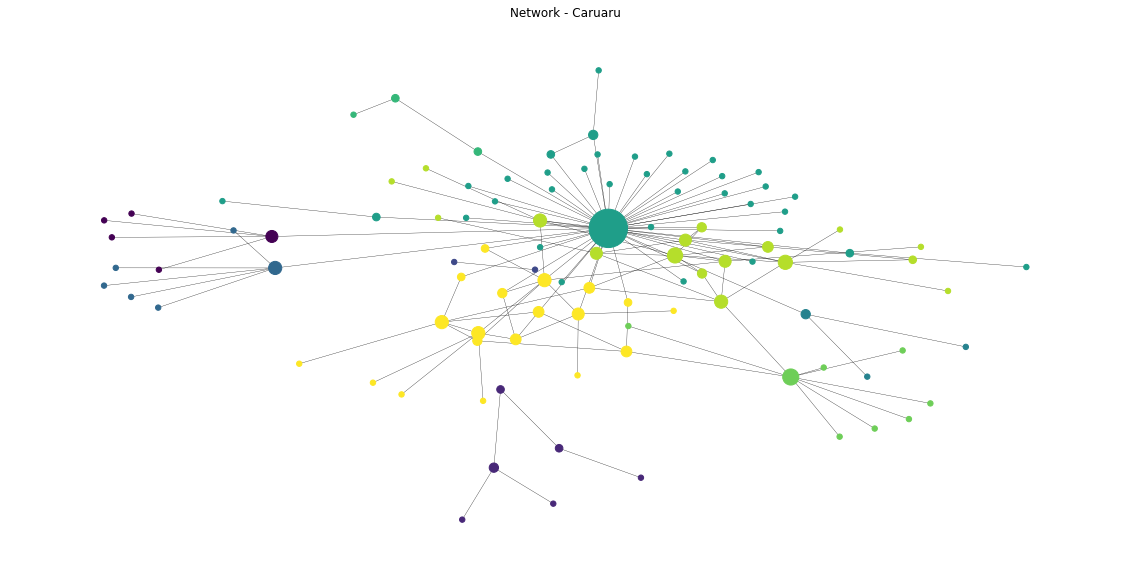

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import networkx.algorithms.community as nx_com
import numpy as np
import community.community_louvain as community_louvain

# create graph from data
G = nx.Graph()
G = nx.from_pandas_edgelist(colab_network_caruaru, 'source', 'target')

# centrality
deg_centrality = nx.degree_centrality(G)
centrality = np.fromiter(deg_centrality.values(), float)

# modularity
label = community_louvain.best_partition(G)
mod = community_louvain.modularity(label, G)
values = [label.get(node) for node in G.nodes()]


# plot
#pos = nx.spring_layout(G)
pos = nx.spring_layout(G, k=0.8*1/np.sqrt(len(G.nodes())), iterations=15, scale=20)
plt.figure(figsize=(20,10))
plt.title("Network - Caruaru")
plt.axis('off')
nx.draw(G, pos, node_color=values, node_size=centrality*3e3, width=0.3)

# Visualização Interativa de redes utilizando o Bokeh
https://docs.bokeh.org/en/latest/docs/user_guide/graph.html?highlight=networks

In [ ]:
import networkx as nx
!pip install pydot
#Choose a title!
#title = 'Network - Rio de Janeiro'

# create graph from data
#G = nx.Graph()
#G = nx.from_pandas_edgelist(colab_users_rj, 'source', 'target')

#Establish which categories will appear when hovering over each node
#HOVER_TOOLTIPS = [("user_id", "@index")]

#Create a plot — set dimensions, toolbar, and title
#plot = figure(tooltips = HOVER_TOOLTIPS,
#              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
#            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title)

#Create a network graph object with spring layout
# https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.drawing.layout.spring_layout.html
#network_graph = from_networkx(G, nx.spring_layout, scale=10, center=(0, 0))

#Set node size and color
#network_graph.node_renderer.glyph = Circle(size=15, fill_color='skyblue')

#Set edge opacity and width
#network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

#Add network graph to the plot
#plot.renderers.append(network_graph)

#show(plot)
from networkx.algorithms import community as community
#
def normalize(values, bounds):
    return [bounds['desired']['lower'] + (x - bounds['actual']['lower']) * (bounds['desired']['upper'] - bounds['desired']['lower']) / (bounds['actual']['upper'] - bounds['actual']['lower']) for x in values]
#
def get_adjusted_node_size(graph_network):
  degrees = nx.degree(graph_network)
  nx.set_node_attributes(graph_network, name='degree', values=dict(degrees))
  #
  centrality = nx.eigenvector_centrality_numpy(graph_network)
  nx.set_node_attributes(graph_network, name='centrality', values=centrality)
  centrality_values = []
  degree_values = []
  for (node) in centrality:
    centrality_values.append(centrality[node])
  max_centrality = max(centrality_values)
  min_centrality = min(centrality_values)
  i=0
  for (node, degree) in degrees:
    degree_values.append(degree)
    i=i+1
  max_degree = max(degree_values)
  print("max_degree", max_degree)
  #print("centrality_values", centrality_values)
  #print("max_centrality", max_centrality)
  #print("min_centrality", min_centrality)
  centrality_values=normalize(centrality_values, {'actual': {'lower': min_centrality, 'upper': max_centrality*2}, 'desired': {'lower': 5, 'upper': 100}})
  sizes = {}
  i=0
  for (node, degree) in degrees:
    sizes[node] = centrality_values[i]
    i=i+1
  #print("centrality_values_normalized", centrality_values)
  #print(sizes)
  adjusted_node_size = dict([(node, sizes[node]) for node, degree in degrees])
  nx.set_node_attributes(graph_network, name='adjusted_node_size', values=adjusted_node_size)
#
def plot_bokeh_network(graph_network, network_communities, title, palette):
  for component in list(nx.connected_components(graph_network)):
    if len(component)<2:
        for node in component:
            graph_network.remove_node(node)
  #
  get_adjusted_node_size(graph_network)
  # Create empty dictionaries
  modularity_class = {}
  modularity_color = {}
  #Loop through each community in the network
  for community_number, community in enumerate(network_communities):
      #For each member of the community, add their community number and a distinct color
      for name in community:
          modularity_class[name] = community_number
          modularity_color[name] = palette[community_number%len(palette)]
  # Add modularity class and color as attributes from the network above
  nx.set_node_attributes(graph_network, modularity_class, 'modularity_class')
  nx.set_node_attributes(graph_network, modularity_color, 'modularity_color')
  #Choose attributes from G network to size and color by — setting manual size (e.g. 10) or color (e.g. 'skyblue') also allowed
  size_by_this_attribute = 'adjusted_node_size'
  color_by_this_attribute = 'modularity_color'
  #Pick a color palette — Blues8, Reds8, Purples8, Oranges8, Viridis8
  color_palette = Blues8
  #Choose colors for node and edge highlighting
  node_highlight_color = 'white'
  edge_highlight_color = 'black'
  #Establish which categories will appear when hovering over each node
  #Establish which categories will appear when hovering over each node
  HOVER_TOOLTIPS = [
          ("user_id", "@index"),
          ("Degree", "@degree"),
          ("Centrality", "@centrality"),
          ("Modularity Class", "@modularity_class"),
          ("Modularity Color", "$color[swatch]:modularity_color"),
  ]

  #Create a plot — set dimensions, toolbar, and title
  plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom', width=1000, height=600, title=title)
  #

  #df = pd.DataFrame(index=graph_network.nodes(), columns=graph_network.nodes())
  #for row, data in nx.shortest_path_length(graph_network):
  #    for col, dist in data.items():
  #        df.loc[row,col] = dist
  #df = df.fillna(df.max().max())

  #layout = nx.spring_layout(graph_network, scale=10, weight='degree')
  #layout = nx.nx_agraph.graphviz_layout(graph_network)
  layout = nx.nx_pydot.graphviz_layout(graph_network, prog="neato")

  #Create a network graph object
  # https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.drawing.layout.spring_layout.html
  network_graph = from_networkx(graph_network, layout, scale=25, k=len(graph_network.nodes())*1/np.sqrt(len(G.nodes())), center=(0, 0))

  #Set node sizes and colors according to node degree (color as category from attribute)
  network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=color_by_this_attribute)
  #Set node highlight colors
  network_graph.node_renderer.hover_glyph = Circle(size=size_by_this_attribute, fill_color=node_highlight_color, line_width=2)
  network_graph.node_renderer.selection_glyph = Circle(size=size_by_this_attribute, fill_color=node_highlight_color, line_width=2)

  #Set edge opacity and width
  network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.3, line_width=0.5)
  #Set edge highlight colors
  network_graph.edge_renderer.selection_glyph = MultiLine(line_color=edge_highlight_color, line_width=2)
  network_graph.edge_renderer.hover_glyph = MultiLine(line_color=edge_highlight_color, line_width=2)
  #
  #Highlight nodes and edges
  network_graph.selection_policy = NodesAndLinkedEdges()
  network_graph.inspection_policy = NodesAndLinkedEdges()
  #
  plot.renderers.append(network_graph)

  show(plot)
#
#get_adjusted_node_size(graph_rj)
#normalize(
    #[1, 0.7232322, 0.93832, 0.4344433],
    #{'actual': {'lower': 0, 'upper': 1}, 'desired': {'lower': 5, 'upper': 50}}
#)
#plot_bokeh_network(graph, communities, 'Network - Caruaru', d3['Category20'][20])

max_degree 51


# Plotando uma rede simples
Plotando a rede de Caruaru utilizando cores para distinguir a centralidade da rede.
Esse foi o exemplo base da documentaçao do Bokeh, que foi evoluido para os exemplos a seguir.

In [ ]:
# create graph from data
G = nx.Graph()
G = nx.from_pandas_edgelist(colab_network_caruaru, 'source', 'target')
#Calculate degree for each node and add as node attribute
degrees = dict(nx.degree(G))
nx.set_node_attributes(G, name='degree', values=degrees)
#Slightly adjust degree so that the nodes with very small degrees are still visible
number_to_adjust_by = 5
adjusted_node_size = dict([(node, degree+number_to_adjust_by) for node, degree in nx.degree(G)])
nx.set_node_attributes(G, name='adjusted_node_size', values=adjusted_node_size)
#
#Choose attributes from G network to size and color by — setting manual size (e.g. 10) or color (e.g. 'skyblue') also allowed
size_by_this_attribute = 'adjusted_node_size'
color_by_this_attribute = 'adjusted_node_size'

#Pick a color palette — Blues8, Reds8, Purples8, Oranges8, Viridis8
color_palette = Blues8

#Choose a title!
title = 'Network - Caruaru'

#Establish which categories will appear when hovering over each node
HOVER_TOOLTIPS = [
       ("user_id", "@index"),
        ("Degree", "@degree")
]

#Create a plot — set dimensions, toolbar, and title
plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title)

#Create a network graph object
# https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.drawing.layout.spring_layout.html\
network_graph = from_networkx(G, nx.spring_layout, scale=10, center=(0, 0))

#Set node sizes and colors according to node degree (color as spectrum of color palette)
minimum_value_color = min(network_graph.node_renderer.data_source.data[color_by_this_attribute])
maximum_value_color = max(network_graph.node_renderer.data_source.data[color_by_this_attribute])
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=linear_cmap(color_by_this_attribute, color_palette, minimum_value_color, maximum_value_color))

#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

plot.renderers.append(network_graph)

show(plot)

# Colab Network - Caruaru

In [ ]:
graph = nx.Graph()
graph = nx.from_pandas_edgelist(colab_network_caruaru, 'source', 'target')
communities = community.greedy_modularity_communities(graph)
plot_bokeh_network(graph, communities, 'Network - Caruaru', d3['Category20'][20])

max_degree 51


# Conexões da Rede - Caruaru

In [ ]:
graph = nx.Graph()
graph = nx.from_pandas_edgelist(colab_network_caruaru, 'source', 'target')
leaderboard = {}
for x in graph.nodes:
 leaderboard[x] = len(graph[x])
s = pd.Series(leaderboard, name='connections')
df2 = s.to_frame().sort_values('connections', ascending=False)
df2

,connections
157493,51
322881,9
313537,8
288189,7
299406,6
...,...
216340,1
253661,1
313457,1
289871,1


# Colab Network - Rio de Janeiro

In [ ]:
graph = nx.Graph()
graph = nx.from_pandas_edgelist(colab_network_rj, 'source', 'target')
communities = community.greedy_modularity_communities(graph)
plot_bokeh_network(graph, communities, 'Network - Rio de Janeiro', d3['Category20'][20])

max_degree 312


# Conexões da Rede - Rio de Janeiro

In [ ]:
graph = nx.Graph()
graph = nx.from_pandas_edgelist(colab_network_rj, 'source', 'target')
leaderboard = {}
for x in graph.nodes:
 leaderboard[x] = len(graph[x])
s = pd.Series(leaderboard, name='connections')
df2 = s.to_frame().sort_values('connections', ascending=False)
df2

,connections
165510,312
116960,70
5710,69
31366,64
169459,63
...,...
35554,1
101938,1
6249,1
93407,1


# Colab Network - Niteroi

In [ ]:
graph = nx.Graph()
graph = nx.from_pandas_edgelist(colab_network_niteroi, 'source', 'target')
communities = community.greedy_modularity_communities(graph)
plot_bokeh_network(graph, communities, 'Network - Niterói', d3['Category20'][20])

max_degree 441


# Conexões da Rede - Niterói

In [ ]:
graph = nx.Graph()
graph = nx.from_pandas_edgelist(colab_network_niteroi, 'source', 'target')
leaderboard = {}
for x in graph.nodes:
 leaderboard[x] = len(graph[x])
s = pd.Series(leaderboard, name='connections')
df2 = s.to_frame().sort_values('connections', ascending=False)
df2

,connections
113450,441
137,359
86,347
247431,323
157493,288
...,...
40215,1
126947,1
126936,1
134541,1


# Colab Network - Recife

In [ ]:
graph = nx.Graph()
graph = nx.from_pandas_edgelist(colab_network_recife, 'source', 'target')
communities = community.greedy_modularity_communities(graph)
plot_bokeh_network(graph, communities, 'Network - Recife', d3['Category20'][20])

max_degree 547


# Conexões da Rede - Recife

In [ ]:
graph = nx.Graph()
graph = nx.from_pandas_edgelist(colab_network_recife, 'source', 'target')
leaderboard = {}
for x in graph.nodes:
 leaderboard[x] = len(graph[x])
s = pd.Series(leaderboard, name='connections')
df2 = s.to_frame().sort_values('connections', ascending=False)
df2

,connections
2,547
157493,272
296688,236
19082,232
155379,187
...,...
114704,1
31474,1
108768,1
3700,1


# Merge de dados de geolocalizacao com dataframe de network


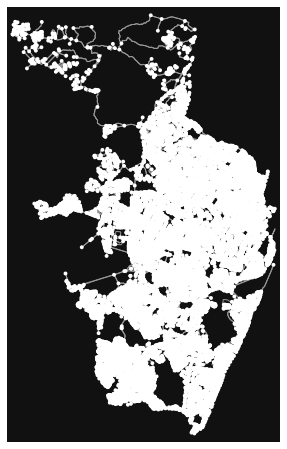

In [ ]:
# obtendo dados de localizaçao fake em recife para servir depontos para postagens sem latxlong
# ja foi solicitado ao DBA a lista de eventos com geolocalizaçao, mas a intenção aqui é somente preparar um book com dados de geoloc para usar no gephi
import osmnx as ox
import random
ox.config(use_cache=True, log_console=True)

#G_re = ox.graph_from_place('Recife, Pernambuco, Brazil', network_type='drive')
#Gp = ox.project_graph(G_re)
#points_recife = ox.utils_geo.sample_points(ox.get_undirected(Gp), 1000)
#fig, ax = ox.plot_graph(ox.project_graph(G_re))

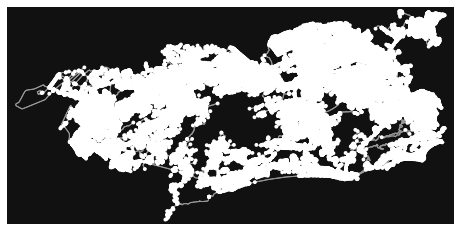

In [ ]:
# obtendo dados de localizaçao fake no rio para servir depontos para postagens sem latxlong
#G_rj = ox.graph_from_place('Rio de Janeiro, Rio de Janeiro, Brazil', network_type='drive')
#Gp = ox.project_graph(G)
#points_rj = ox.utils_geo.sample_points(ox.get_undirected(Gp), 1000)
#fig, ax = ox.plot_graph(ox.project_graph(G))


In [ ]:
# traduzindo o complexo esquema de pontos da lib para uma simples array de latxlng
#latlng_rj = []
#nodes_rj = G_rj.nodes
#for index, poi in pd.DataFrame(points_rj).iterrows():
  #latlng_rj.append(nodes_rj[index[0]])
#latlng_rj
#def setLatLngRJ(v):
  #pos = random.choice(latlng_rj)
  #return [pos['y'], pos['x']]
#
#latlng_re = []
#nodes_re = G_re.nodes
#for index, poi in pd.DataFrame(points_recife).iterrows():
 # latlng_re.append(nodes_re[index[0]])
#latlng_re
#def setLatLngRE(v):
 # pos = random.choice(latlng_re)
  #return [pos['y'], pos['x']]
#

In [ ]:
# esse bloco é temporario. a intençao dele é fazer o merge do arquivo de eventos com geolocalizaçao e o arquivo de eventos novo sem geolocalizaçao
# para os itens que sao nulos, vamos adicionar geolocalizacao fake so para testar no gephi.
# a ideia é gerar outro arquivo csv com esses dados reais uma vez que o dataset de eventos esteja disponivel com a geolocalizaçao
#colab_events_url_niteroi = "https://drive.google.com/uc?id=1_1JAZfGF2QfXCTHtEBEwvD-i0m201DNG&export=download" #2020-2022 Niteroi - Clean
#colab_events_niteroi = ReadCSV(colab_events_url_niteroi, None)
#print("niteroi", colab_events_niteroi.shape)
#colab_events_niteroi.head(1)

#unique_events_by_user = colab_events_niteroi.drop_duplicates(subset=['user_id'])[['user_id', 'lat', 'lng']]
#unique_events_by_user['user_id'] = unique_events_by_user['user_id'].astype('int')
#print("unique niteroi events", unique_events_by_user.shape)
#unique_colab_events= pd.DataFrame(colab_events.drop_duplicates(subset=['user_id'], keep='last')['user_id'])
#
#print("all events", unique_colab_events.shape)
unique_colab_events

#df_all = pd.merge(unique_events_by_user, unique_colab_events, on=['user_id'], how='left', indicator=False)
#print("all events", df_all.shape)
#df_all['city_name'] = 'Niteroi'
#df_all.head(10)

#
#colab_users_cities = colab_users.drop_duplicates(subset=['colab_user_id'])[['colab_user_id', 'city_name']]
#colab_users_cities=colab_users_cities.rename(columns={"colab_user_id":"user_id"})
#colab_users_cities = colab_users_cities.drop(colab_users_cities.query("city_name not in ['Recife', 'Niteroi', 'Rio de Janeiro']").index)
#colab_users_cities = pd.merge(colab_users_cities, df_all, on=['user_id'], how='left', indicator=False)
#colab_users_cities.loc[colab_users_cities['city_name_y'] == "Niteroi", "city_name_x"] = "Niteroi"
#colab_users_cities=colab_users_cities.rename(columns={"city_name_x":"city_name"})
#colab_users_cities=colab_users_cities.drop(['city_name_y'], axis=1)
#colab_users_cities

niteroi (35574, 9)
unique niteroi events (5631, 3)
all events (51566, 1)
all events (5631, 3)


,user_id,city_name,lat,lng
0,1,Recife,NaN,NaN
1,2,Recife,NaN,NaN
2,3,Recife,NaN,NaN
3,11,Recife,NaN,NaN
4,12,Recife,NaN,NaN
...,...,...,...,...
3253,687017,Rio de Janeiro,NaN,NaN
3254,687339,Rio de Janeiro,NaN,NaN
3255,687543,Rio de Janeiro,NaN,NaN
3256,688386,Rio de Janeiro,NaN,NaN


In [ ]:


for ind, row in colab_users_cities.iterrows():
  if row['city_name'] == 'Rio de Janeiro':
      pos = setLatLngRJ(None)
      colab_users_cities.loc[ ind, 'lat'] = pos[0]
      colab_users_cities.loc[ ind, 'lng'] = pos[1]
  elif row['city_name'] == 'Recife':
      pos = setLatLngRE(None)
      colab_users_cities.loc[ ind, 'lat'] = pos[0]
      colab_users_cities.loc[ ind, 'lng'] = pos[1]
DownloadDataFrame(colab_users_cities, "colab_users_cities_mock.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
DownloadDataFrame(colab_network_niteroi, "colab_network_niteroi.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Merge de usuários e seus seguidores em um unico csv

In [ ]:
#
# usuários que tem postagens no colab
#
#colab_users_url = "https://drive.google.com/uc?id=1-P0Y9q27tDWQq2HD5PYgySmu1UBlJwO7&export=download" #2020-2022 Niteroi - Clean
#colab_users_url = "https://drive.google.com/uc?id=16gqijd_rNssCV2bWy09cyPJWh4c0ycbe&export=download" #New File (all data)
#colab_users_url = "https://drive.google.com/uc?id=1MCyRDc_lty7m2UVKeAFse2vDust2Mtg4&export=download" #05-20 File (all data)
#colab_users = ReadAndValidateColabUsers(colab_users_url)
#print(colab_users.shape)
#colab_users.head(1)
#
# seguidores de usuarios que tem postagens no colab
#
#colab_users_followers_url = "https://drive.google.com/uc?id=125MHZFOmhok7avkMpxZiHEejZt9kLkXQ&export=download" #New File (all data)
#colab_users_followers_url = "https://drive.google.com/uc?id=1lbIpMG_AoQrx_dlkDTqTHl9F7EvLlxyC&export=download" #05-20 File (all data)
#colab_users_followers = ReadAndValidateColabUsers(colab_users_followers_url)
#print(colab_users_followers.shape)
#colab_users_followers.head(1)
##
#df1=colab_users
#df2=colab_users_followers
##
#df_all = pd.concat([colab_users.set_index('colab_user_id'), colab_users_followers.set_index('colab_user_id')], axis='columns', keys=['First', 'Second'])
#df_final = df_all.swaplevel(axis='columns')[colab_users.columns[1:]]
#df_final
#
# concatenando usuários com seus seguidores em uma unica planilha sem duplicados
#
#result = pd.concat([df1,df2])
#idx = np.unique(result["colab_user_id"], return_index=True)[1]
#colab_users_and_followers =result.iloc[idx]
#colab_users_and_followers
#DownloadDataFrame(colab_users_and_followers, "colab_users_and_followers.csv")

validating colab_users file
Index(['colab_user_id', 'gender', 'birth_date', 'city_id', 'city_name',
       'state_id', 'state_name', 'created_at', 'last_sign_in_at', 'device'],
      dtype='object')
[]
File is clean
(49353, 10)
validating colab_users file
Index(['colab_user_id', 'gender', 'birth_date', 'city_id', 'city_name',
       'state_id', 'state_name', 'created_at', 'last_sign_in_at', 'device'],
      dtype='object')
[]
File is clean
(19678, 10)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>